# Capstone Project Pneumonia Image Recognition with CNN and tensorflow

# Problem Statement
How can images of infant chest X Rays be viewed algorithmicly such that Pneumonia can be detected from Normal conditions with a high level of confidence?

A Deep Learning algorithm of Convolution Neural Networks will be applied to images of pediatric X Rays separated into Pneumonia and Normal groups to determine if images can predict results based on training a model on the dataset

Images from the Kaggle Dataset: Pediatric Phneumonia Chest X-ray
https://www.kaggle.com/andrewmvd/pediatric-pneumonia-chest-xray

Code references from Towards Data Science: https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a

Dataset by Daniel Kermany and Michael Goldbaum in 2018.  The data includes 5,856 images labelled as either pneumonia or normal 

Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2
http://dx.doi.org/10.17632/rscbjbr9sj.2

In [1]:
# typical imports
import os
import random
import shutil
import sys

import matplotlib.pyplot as plt  # To visualize data
import numpy as np               # For arrays
import pandas as pd              # For holding and handling data
import seaborn as sns            # for confusion matrix plotting
from sklearn.metrics import accuracy_score, plot_confusion_matrix   # for metrics
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score  # for metrics

# image processing imports
import cv2                       # For image to file handling
import glob                      # to read all files in directory

# for preprocessing the images
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping,History
history = History()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

# for reading images from folders
from tensorflow.keras.preprocessing.image import DirectoryIterator  

# determines class weights as array of class weight vectors
#from sklearn.utils.class_weight import compute_class_weigh

In [2]:
# Define Overall Structure for modeling
# Directories for train, test, and validation datasets
normal_train_path = 'CS_Pneumonia/dataset/train/NORMAL'
pneumonia_train_path = 'CS_Pneumonia/dataset/train/PNEUMONIA'
normal_test_path = 'CS_Pneumonia/dataset/test/NORMAL'
pneumonia_test_path = 'CS_Pneumonia/dataset/test/PNEUMONIA'
normal_valid_path = 'CS_Pneumonia/dataset/valid/NORMAL'
pneumonia_valid_path = 'CS_Pneumonia/dataset/valid/PNEUMONIA'

# Batch size is number of trainging examples per iteration
batch_size = 20

# Dimension size of images set as 400x400 to limit loading on machine
img_height = 300
img_width = 300

# Loading the images

In [3]:
# method to move files randomly between source and dest directories 
# given percentage of files to move
def move_pics(s,d,percent):
    file_list = [f for f in os.listdir(s) if os.path.isfile(os.path.join(s, f))]
    num_files_to_move = int(len(file_list)*percent)
    
    
    for i in range(num_files_to_move):
        random_file = random.choice(os.listdir(s))
        source_file = s+'/'+random_file
        shutil.move(source_file,d)
    print('Files moved:',num_files_to_move,'from',s,'to',d)

In [4]:
# Make a VALID directory of images 
# Create Valid directory of files by pulling 10% from train directory
# pull 10% from both PNEUMONIA and NORMAL folders

# The following 2 lines were executed once to move files, then commented out
#move_pics(pneumonia_train_path,pneumonia_valid_path,0.1)
#move_pics(normal_train_path,normal_valid_path,0.1)

In [5]:
# Read in the separate files of images, separated by separate folders for test/train
# within TEST/TRAIN separated by folders for PNEUMONIA and NORMAL
# glob function recursively opens all files in folder
path_train_pneumonia = glob.glob(pneumonia_train_path+"/*.jpeg")
path_train_normal = glob.glob(normal_train_path+"/*.jpeg")
path_test_pneumonia = glob.glob(pneumonia_test_path+"/*.jpeg")
path_test_normal = glob.glob(normal_test_path+"/*.jpeg")
categories = ['NORMAL','PNEUMONIA']
folders = ['train', 'test', 'valid']

# Move images into correct folders (Train, Test, Valid) and discard ratios and sizes outside of 2 std

In [6]:
# read all files using glob method and record their features in DataFrame
# An initial run of this code produced descriptive statistics on all of the pictures
# From this analysis, it was determined to remove outliers with ratio sizes < 0.58 and > 0.84
# From this analysis, it was also determined to remove any file with pixel counts < 400 (file too low resolution)
file_list = []
discard_ratio,discard_size = 0,0
source_dest = 'CS_Pneumonia/dataset/'
discard_dest = 'CS_Pneumonia/dataset/discard/'
for f in folders:                                 # train, test, or valid
    for c in categories:                          # pneumonia, normal
        for n in glob.glob(source_dest+f+'/'+c+'/*.jpeg'):
            img = cv2.imread(n)
            # cv2.shape provides information for each image as 
            #height, width, number of channels of image
            width = img.shape[1]      # width
            height = img.shape[0]      # height
            ratio = height/width
            file_name = os.path.basename(n)
            # exception files move to discard folder
            if ratio < 0.58 or ratio > 0.84 or height < 400:   
                shutil.move(n,(discard_dest+c))
                discard_ratio += 1
            elif height < 400:
                shutil.move(n,(discard_dest+c))
                discard_size += 1
            else:
                info = [file_name,f,c,width,height,ratio]
                file_list.append(info)
                
print("pictures in database for modeling           : ",len(file_list))
print("pictures discarded for ratio outside bounds : ",discard_ratio)
print("pictures discarded for size too small.      : ",discard_size)
df_pics = pd.DataFrame(file_list)
df_pics.columns = ['File','Data Set','Result','Width','Height','Ratio']
df_pics.head()

pictures in database for modeling           :  4321
pictures discarded for ratio outside bounds :  0
pictures discarded for size too small.      :  0


,File,Data Set,Result,Width,Height,Ratio
0,NORMAL2-IM-1056-0001.jpeg,train,NORMAL,1422,1067,0.750352
1,IM-0427-0001.jpeg,train,NORMAL,1828,1357,0.742341
2,NORMAL2-IM-1260-0001.jpeg,train,NORMAL,1854,1495,0.806365
3,NORMAL2-IM-1326-0001.jpeg,train,NORMAL,1188,885,0.744949
4,NORMAL2-IM-0736-0001.jpeg,train,NORMAL,1432,1184,0.826816


In [7]:
# Verify the characteristic features only have 2 values, and show channels for color
print("Data Set",df_pics['Data Set'].unique())
print("Test(1) or Train(0) Data",df_pics['Result'].unique())

Data Set ['train' 'test' 'valid']
Test(1) or Train(0) Data ['NORMAL' 'PNEUMONIA']


In [8]:
# Determine the typical ratio of Height/Width for the dataset
df_pics['Ratio'].describe()

count    4321.000000
mean        0.705529
std         0.070159
min         0.580153
25%         0.648276
50%         0.702899
75%         0.762759
max         0.840000
Name: Ratio, dtype: float64

From the 4321 pictures provided (both test, train, and valid) the typical ratio is 0.70 (Height/Width), However we need to look at the range of file sizes to determine if they can all be used.  We also see that all images use 3 color channels so they must be converted to grayscale which is 1 color channel.

In [9]:
df_pics.head()

,File,Data Set,Result,Width,Height,Ratio
0,NORMAL2-IM-1056-0001.jpeg,train,NORMAL,1422,1067,0.750352
1,IM-0427-0001.jpeg,train,NORMAL,1828,1357,0.742341
2,NORMAL2-IM-1260-0001.jpeg,train,NORMAL,1854,1495,0.806365
3,NORMAL2-IM-1326-0001.jpeg,train,NORMAL,1188,885,0.744949
4,NORMAL2-IM-0736-0001.jpeg,train,NORMAL,1432,1184,0.826816


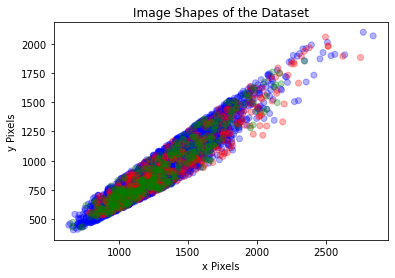

In [10]:
# Scatterplot of Width and Height parameters to show sizing
colors = df_pics['Data Set'].map({'train':'b', 'test':'r', 'valid':'g'})
fig, ax = plt.subplots()
ax.scatter(df_pics['Width'],df_pics['Height'],c=colors, alpha=0.3)
ax.set_xlabel("x Pixels")
ax.set_ylabel("y Pixels")
ax.set_title("Image Shapes of the Dataset")
plt.show()

The scatter plot reveals that the images are split between train(blue), test(red), and valid(green) data sets.  The distribution of sizes appears common between these splits

# Data Wrangling

In [11]:
# Data PreProcessing
def image_preprocess(path):
    # Start empty list of each category (path) called
    images = []
    for i in path:
        # read the image
        img = cv2.imread(i)
        # resize
        img = cv2.resize(img,
                         dsize = (img_height,img_width), 
                         interpolation = cv2.INTER_CUBIC)
        # adjust brightness, contrast
        alpha = 1.0      # contrast
        beta = 1.0       # brightness
        img = cv2.addWeighted(img,
                              alpha,
                              np.zeros(img.shape, img.dtype),
                              0,beta)
        # Normalize the images 
        img = cv2.bitwise_not(img)
        img = img/255
        # append onto list of images
        images.append(img)
    # return the filled list of images
    return images

In [12]:
# Read files into the folders with preprocessing applied, observe image counts
# counts are [normal,pneumonia]
train_img_count, test_img_count, valid_img_count = [0,0], [0,0], [0,0]

# Training
img_train_normal = image_preprocess(path=glob.glob(normal_train_path+"/*.jpeg"))
train_img_count[0] = len(img_train_normal)
img_train_pneumonia = image_preprocess(path=glob.glob(pneumonia_train_path+"/*.jpeg"))
train_img_count[1] = len(img_train_pneumonia)

# Testing
img_test_normal = image_preprocess(path=glob.glob(normal_test_path+"/*.jpeg"))
test_img_count[0] = len(img_test_normal)
img_test_pneumonia = image_preprocess(path=glob.glob(pneumonia_test_path+"/*.jpeg"))
test_img_count[1] = len(img_test_pneumonia)

# Validation
img_valid_normal = image_preprocess(path=glob.glob(normal_valid_path+"/*.jpeg"))
valid_img_count[0] = len(img_valid_normal)
img_valid_pneumonia = image_preprocess(path=glob.glob(pneumonia_valid_path+"/*.jpeg"))
valid_img_count[1] = len(img_valid_pneumonia)

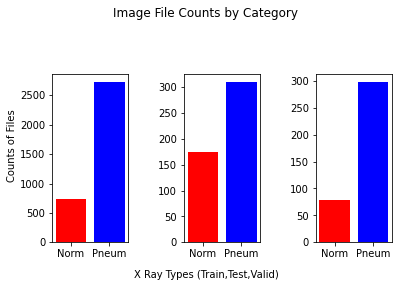

In [13]:
# Review file counts for all categories
fig, ax = plt.subplots(1, 3)
fig.suptitle('Image File Counts by Category')

#ax[0].set_color('r')
ax[0].bar(['Norm','Pneum'],train_img_count, color=['r','b'])
ax[1].bar(['Norm','Pneum'],test_img_count, color=['r','b'])
ax[2].bar(['Norm','Pneum'],valid_img_count, color=['r','b'])
fig.tight_layout(pad=3.0)
fig.text(0.5,0.04,'X Ray Types (Train,Test,Valid)', ha='center')
fig.text(0.04,0.5, 'Counts of Files', va='center', rotation='vertical')
plt.show()

In [14]:
# Create labels for the images
# Training
y_train_normal = [0 for i in range(0,len(img_train_normal))]
y_train_pneumonia = [1 for i in range(0,len(img_train_pneumonia))]
# Testing
y_test_normal = [0 for i in range(0,len(img_test_normal))]
y_test_pneumonia = [1 for i in range(0,len(img_test_pneumonia))]
# Validation
y_valid_normal = [0 for i in range(0,len(img_valid_normal))]
y_valid_pneumonia = [1 for i in range(0,len(img_valid_pneumonia))]

# Modeling

In [15]:
# Define  X_train, X_test, y_train, y_test for analysis
X_train = np.concatenate((img_train_normal, img_train_pneumonia), axis = 0)
X_test = np.concatenate((img_test_normal, img_test_pneumonia), axis = 0)
X_valid = np.concatenate((img_valid_normal, img_valid_pneumonia), axis = 0)
y_train = np.concatenate((y_train_normal, y_train_pneumonia), axis = 0)
y_test = np.concatenate((y_test_normal, y_test_pneumonia), axis = 0)
y_valid = np.concatenate((y_valid_normal, y_valid_pneumonia), axis = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_valid.shape)
print(y_valid.shape)

(3463, 300, 300, 3)
(3463,)
(483, 300, 300, 3)
(483,)
(375, 300, 300, 3)
(375,)


In [16]:
# Create method to return arrays that maintain labels and are randomized, return as np.array
def shuffle_label_array(arrays,labels):
    shuffle = []
    for i,j in enumerate(arrays):
        # brings images and labels together into same array
        new_array = (j,labels[i])
        shuffle.append(new_array)  # append onto the array
    temp_array = np.array(shuffle)
    np.random.shuffle(temp_array)     # shuffle the array
    return temp_array

In [17]:
# Now split back apart keeping the order association for separate lists
def split_label_array(array):
    X_data = []                    # temporary X array
    y_data = []                    # temporary y array
    for a in array:
        # pull images and labels apart
        X_data.append(a[0])        # image
        y_data.append(a[1])        # label
    return np.array(X_data), np.array(y_data)

In [18]:
# Update data arrays to have image and label together, shuffled
X_train_shuffle = shuffle_label_array(X_train,y_train)
print(X_train_shuffle.shape)
X_test_shuffle = shuffle_label_array(X_test,y_test)
print(X_test_shuffle.shape)
X_valid_shuffle = shuffle_label_array(X_valid,y_valid)
print(X_valid_shuffle.shape)

(3463, 2)
(483, 2)
(375, 2)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [19]:
# split arrays apart but still have y array with correct labels associated, verify sizes again
X_train,y_train = split_label_array(X_train_shuffle)
print(X_train.shape)
print(y_train.shape)
X_test,y_test = split_label_array(X_test_shuffle)
print(X_test.shape)
print(y_test.shape)
X_valid,y_valid = split_label_array(X_valid_shuffle)
print(X_valid.shape)
print(y_valid.shape)

(3463, 300, 300, 3)
(3463,)
(483, 300, 300, 3)
(483,)
(375, 300, 300, 3)
(375,)


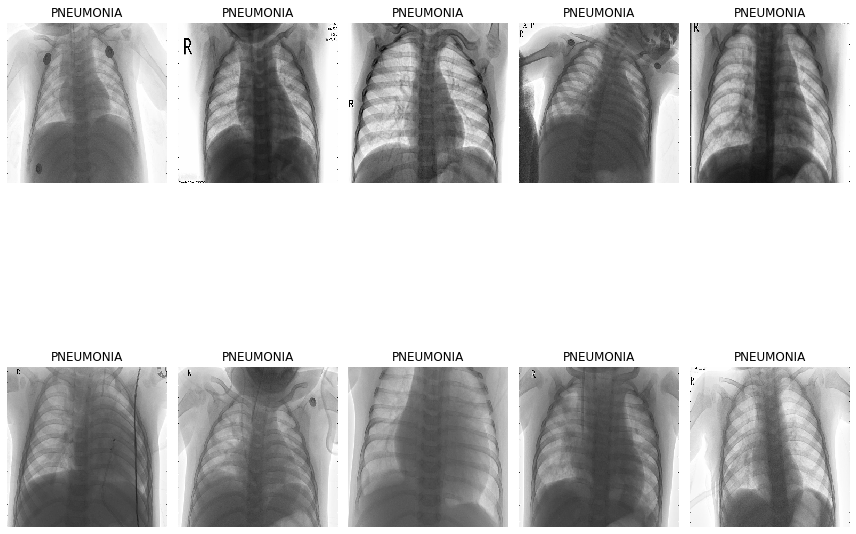

In [20]:
# View images
# Display batch of images to see results of import
plt.figure(figsize=(12,12))
for i in range(10):
    plt.subplot(2,5,i+1)
    for index in range(len(X_train)):
        image = X_train[i]        
        dic = {0:'NORMAL',1:'PNEUMONIA'}
        plt.title(dic.get(y_train[i]))   # labels imbeded based on folder structure of data on build
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray', interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# Define methods for displaying results

In [21]:
# Method to Display results for model
def model_results(m,xt,yt):    # m-model, xt-X_test data, yt- y_test labels

    print('*****  RESULTS  *****')
    #model_results(model,test_data,test_labels,valid)
    print("test data set",len(xt))
    predictions = m.predict(xt)
    # turn predictions into 0 and 1 values. Sigmoid output is 0 to 1 so split on 0.5
    predictions_values = []
    for i in predictions:
        if i < 0.5:
            predictions_values.append(0)
        if i >= 0.5:
            predictions_values.append(1)

    # Plot confusion matrix
    print('*****  Confusion Matrix  *****')
    print(confusion_matrix(yt, predictions_values))

    print('*****  Classification Report  *****')
    print(classification_report(yt,predictions_values,target_names=categories))

    print('*****  Metric Scores  *****')
    # accuracy: (tp + tn_ / (p + n)
    accuracy = accuracy_score(yt,predictions_values)
    print('Accuracy : %f' % accuracy)

    # precision: tp / (tp + fp)
    precision = precision_score(yt,predictions_values)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(yt,predictions_values)
    print('Recall   : %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(yt,predictions_values)
    print('F1 score : %f' % f1)

# CNN Model Build
Convolutional layers: (input data image with 2D convolutional layers) Creates feature map. Depth of filter same as depth of input- grayscale is 1.  Will apply a Sequential model to allow us to build layer by layer

Determining the dimension of activation maps:
(N + 2P — F)/ S + 1; where N = Dimension of image (input) file
P = Padding
F = Dimension of filter
S = Stride

ReLu layers: (Rectified Linear Unit - linear function to output directly if positive, otherwise zero) Increases non-linearity. _Better than Sigmoid and Tanh based on overcoming the vanishing gradient problem.

Pooling layers: Combine to create spatial variance, make objects detectable no matter where they are located in the image

Flattening: make long vector of pooled features

Fully connect layer: Input vector into neural network.  Process features through the network.  The fully connected layers votes on the classes

Train the model: using forward propagation and backpropagation, trains the neural network with weights and feature detectors


In [22]:
# Create the model
model = Sequential()

# Add model layers
model.add(Conv2D(32, (3,3),
                activation='relu',kernel_initializer='he_uniform',padding='same',
                input_shape=(img_width, img_height,3)))
model.add(MaxPooling2D((2,2)))
# number of nodes in each layer - 32
# activation - relu model for rectified linear
# input_shape - pizel size of image
# pool_size - reduce feature map by factor of 2, typically (2,2)
          
# Now flatten the layers
model.add(Flatten())

# Use Dense to lower shape down to 1 output
model.add(Dense(128,activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dense(1,activation='sigmoid'))


In [23]:
# Compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#   optimizer controls the learning rate: 
#.    "Adam" good general use-adjusts lerning rate throughout training
#   loss function: binary_crossentropy, for binary (2 choice) problems
#   metrics: accuracy

In [24]:
# Look at model summary to determine layer sizes
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 720000)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               92160128  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 92,161,153
Trainable params: 92,161,153
Non-trainable params: 0
_________________________________________________________________


# Fit Model

In [25]:
# Set a validation set of data to set early stopping point for model fit
my_callbacks = [EarlyStopping(monitor='accuracy', mode='max', min_delta= 0.01, patience = 2)]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_valid.shape)
print(y_valid.shape)

(3463, 300, 300, 3)
(3463,)
(483, 300, 300, 3)
(483,)
(375, 300, 300, 3)
(375,)


In [26]:
# fit the model
history = model.fit(X_train, y_train, epochs = 25, validation_data=(X_valid,y_valid), callbacks=my_callbacks)

Epoch 1/25
109/109 [==============================] - 84s 755ms/step - loss: 0.6719 - accuracy: 0.7569 - val_loss: 0.2949 - val_accuracy: 0.7920
Epoch 2/25
109/109 [==============================] - 73s 666ms/step - loss: 0.3001 - accuracy: 0.8386 - val_loss: 0.2374 - val_accuracy: 0.9547
Epoch 3/25
109/109 [==============================] - 73s 666ms/step - loss: 0.2561 - accuracy: 0.9223 - val_loss: 0.2380 - val_accuracy: 0.9120
Epoch 4/25
109/109 [==============================] - 73s 667ms/step - loss: 0.2524 - accuracy: 0.9241 - val_loss: 0.2209 - val_accuracy: 0.9200
Epoch 5/25
109/109 [==============================] - 73s 671ms/step - loss: 0.2184 - accuracy: 0.9382 - val_loss: 0.1904 - val_accuracy: 0.9573
Epoch 6/25
109/109 [==============================] - 73s 669ms/step - loss: 0.2141 - accuracy: 0.9353 - val_loss: 0.2121 - val_accuracy: 0.9280
Epoch 7/25
109/109 [==============================] - 73s 670ms/step - loss: 0.1879 - accuracy: 0.9454 - val_loss: 0.6412 - val_ac

<AxesSubplot:>

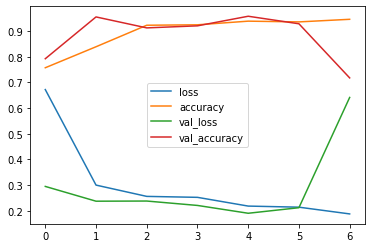

In [27]:
#Visualize the progress of the metrics throughout the epocks
pd.DataFrame(history.history).plot()

In [28]:
print('Training Accuracy based on Test Dataset')
test_accuracy = model.evaluate(X_test,y_test,verbose=0)
print('Model loss is : ',test_accuracy[0]*100,'%')
print('Model Accuracy is : ',test_accuracy[1]*100,'%')

Training Accuracy based on Test Dataset
Model loss is :  50.99866986274719 %
Model Accuracy is :  78.2608687877655 %


In [29]:
# Call method to Display Results for model 1
model_results(model,X_test,y_test)

*****  RESULTS  *****
test data set 483
*****  Confusion Matrix  *****
[[147  27]
 [ 78 231]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.65      0.84      0.74       174
   PNEUMONIA       0.90      0.75      0.81       309

    accuracy                           0.78       483
   macro avg       0.77      0.80      0.78       483
weighted avg       0.81      0.78      0.79       483

*****  Metric Scores  *****
Accuracy : 0.782609
Precision: 0.895349
Recall   : 0.747573
F1 score : 0.814815


# Improving the Model (Model2)
The results from the first model did not meet expectations
The graph shows multiple epochs with high accuracy and low loss
But the resultant accuracy applying the test set was below expectations at 78.2%

The model was run with (alpha, beta) values ranging from (0.8,0.8) to (1.1,1.1) with combinations in between.  The resultant lowest accuracy from Model 1 was 71.6%.  For values alpha=1.0 and beta=1.0 the best results occurred.  Model 1 at 78.2% accuracy was the best result.
 
Additional layers are added to model and the Dense add will be changed to 64 units

In [30]:
# Create the model
model2 = Sequential()

# Add model layers
model2.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 3)))
model2.add(MaxPooling2D((2,2)))
# number of nodes in each layer - 32
# activation - relu model for rectified linear
# input_shape - pizel size of image
# pool_size - reduce feature map by factor of 2, typically (2,2)

# Add another model layer to further reduce shape
model2.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 3)))
model2.add(MaxPooling2D(pool_size = (2,2)))

# Add another model layer to further reduce shape
model2.add(Conv2D(64, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 3)))
model2.add(MaxPooling2D(pool_size = (2,2)))      
    
    
# Now flatten the layers
model2.add(Flatten())

# Use Dense to lower shape down to 1 output
model2.add(Dense(64,activation ='relu'))
model2.add(Dense(1,activation='sigmoid'))

# Set a validation set of data to set early stopping point for model fit
my_callbacks = [EarlyStopping(monitor='accuracy', mode='max', min_delta= 0.01, patience = 2)]

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# Look at model2 summary to determine layer sizes
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 78400)            

In [32]:
# fit the updated model2
history2 = model2.fit(X_train, y_train, epochs = 25, validation_data=(X_valid,y_valid), callbacks=my_callbacks)

Epoch 1/25
109/109 [==============================] - 110s 998ms/step - loss: 0.2700 - accuracy: 0.8934 - val_loss: 0.0951 - val_accuracy: 0.9760
Epoch 2/25
109/109 [==============================] - 101s 920ms/step - loss: 0.1023 - accuracy: 0.9625 - val_loss: 0.0662 - val_accuracy: 0.9813
Epoch 3/25
109/109 [==============================] - 97s 894ms/step - loss: 0.0608 - accuracy: 0.9743 - val_loss: 0.0791 - val_accuracy: 0.9707
Epoch 4/25
109/109 [==============================] - 102s 934ms/step - loss: 0.0657 - accuracy: 0.9752 - val_loss: 0.0616 - val_accuracy: 0.9813
Epoch 5/25
109/109 [==============================] - 104s 957ms/step - loss: 0.0409 - accuracy: 0.9856 - val_loss: 0.0643 - val_accuracy: 0.9813
Epoch 6/25
109/109 [==============================] - 102s 933ms/step - loss: 0.0545 - accuracy: 0.9789 - val_loss: 0.1178 - val_accuracy: 0.9653
Epoch 7/25
109/109 [==============================] - 102s 935ms/step - loss: 0.0429 - accuracy: 0.9833 - val_loss: 0.0461 - 

<AxesSubplot:>

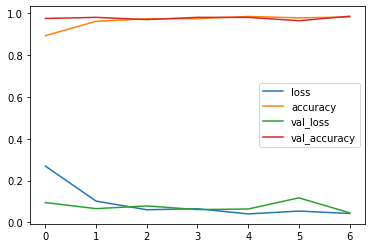

In [33]:
#Visualize the progress of the metrics throughout the epocks
pd.DataFrame(history2.history).plot()

In [34]:
print('Training Accuracy based on Test Dataset')
test_accuracy = model2.evaluate(X_test,y_test,verbose=0)
print('Model loss is : ',test_accuracy[0]*100,'%')
print('Model Accuracy is : ',test_accuracy[1]*100,'%')

Training Accuracy based on Test Dataset
Model loss is :  193.69157552719116 %
Model Accuracy is :  74.53415989875793 %


In [35]:
# Display Results for model 2
print('*****  Model 2  *****')
model_results(model2,X_test,y_test)

*****  Model 2  *****
*****  RESULTS  *****
test data set 483
*****  Confusion Matrix  *****
[[ 52 122]
 [  1 308]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.98      0.30      0.46       174
   PNEUMONIA       0.72      1.00      0.83       309

    accuracy                           0.75       483
   macro avg       0.85      0.65      0.65       483
weighted avg       0.81      0.75      0.70       483

*****  Metric Scores  *****
Accuracy : 0.745342
Precision: 0.716279
Recall   : 0.996764
F1 score : 0.833559


# Improving the Model a third time (Model3)
The results from the second model were worse than Model 1, with a far greater False Negative scoring on the model.
Based on the Early Stopping parameter to prevent overfitting, the model stopped at Epoch 7,
however the results were not as good as Model 1 even though it was the same model with an additional layer added.
To test the capabilities of the model, add more Additional layers to see the result. 

In [36]:
# Create the model
model3 = Sequential()

# Add model layers
model3.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 3)))
model3.add(MaxPooling2D((2,2)))
# number of nodes in each layer - 32
# activation - relu model for rectified linear
# input_shape - pizel size of image
# pool_size - reduce feature map by factor of 2, typically (2,2)

# Add another model layer to further reduce shape
model3.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 3)))
model3.add(MaxPooling2D(pool_size = (2,2)))

# Add another model layer to further reduce shape
model3.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 3)))
model3.add(MaxPooling2D(pool_size = (2,2)))      

# Add another model layer to further reduce shape
model3.add(Conv2D(64, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 3)))
model3.add(MaxPooling2D(pool_size = (2,2))) 

# Add another model layer to further reduce shape
model3.add(Conv2D(64, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 3)))
model3.add(MaxPooling2D(pool_size = (2,2))) 
    
    
# Now flatten the layers
model3.add(Flatten())

# Use Dense to lower shape down to 1 output
model3.add(Dense(activation = 'relu', units=32))
model3.add(Dense(activation='sigmoid', units=1))
# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
# Look at model3 summary to determine layer sizes
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 33, 33, 64)       

In [38]:
# fit the updated model3
history3 = model3.fit(X_train, y_train, epochs = 25, validation_data=(X_valid,y_valid), callbacks=my_callbacks)

Epoch 1/25
109/109 [==============================] - 112s 1s/step - loss: 0.4984 - accuracy: 0.7935 - val_loss: 0.2318 - val_accuracy: 0.9040
Epoch 2/25
109/109 [==============================] - 103s 944ms/step - loss: 0.2240 - accuracy: 0.9119 - val_loss: 0.1631 - val_accuracy: 0.9547
Epoch 3/25
109/109 [==============================] - 96s 881ms/step - loss: 0.1589 - accuracy: 0.9396 - val_loss: 0.1196 - val_accuracy: 0.9653
Epoch 4/25
109/109 [==============================] - 100s 917ms/step - loss: 0.1302 - accuracy: 0.9500 - val_loss: 0.1229 - val_accuracy: 0.9733
Epoch 5/25
109/109 [==============================] - 99s 911ms/step - loss: 0.1056 - accuracy: 0.9573 - val_loss: 0.1536 - val_accuracy: 0.9493
Epoch 6/25
109/109 [==============================] - 100s 917ms/step - loss: 0.0873 - accuracy: 0.9662 - val_loss: 0.0876 - val_accuracy: 0.9760
Epoch 7/25
109/109 [==============================] - 99s 907ms/step - loss: 0.0958 - accuracy: 0.9648 - val_loss: 0.0811 - val_a

<AxesSubplot:>

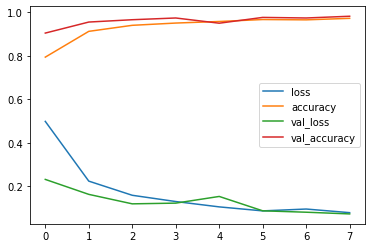

In [39]:
#Visualize the progress of the metrics throughout the epocks
pd.DataFrame(model3.history.history).plot()

In [40]:
print('Training Accuracy based on Test Dataset')
test_accuracy = model3.evaluate(X_test,y_test,verbose=0)
print('Model loss is : ',test_accuracy[0]*100,'%')
print('Model Accuracy is : ',test_accuracy[1]*100,'%')

Training Accuracy based on Test Dataset
Model loss is :  124.12244081497192 %
Model Accuracy is :  72.87784814834595 %


In [41]:
# Display Results for model 3
print('*****  Model 3  *****')
model_results(model3,X_test,y_test)

*****  Model 3  *****
*****  RESULTS  *****
test data set 483
*****  Confusion Matrix  *****
[[ 44 130]
 [  1 308]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.98      0.25      0.40       174
   PNEUMONIA       0.70      1.00      0.82       309

    accuracy                           0.73       483
   macro avg       0.84      0.62      0.61       483
weighted avg       0.80      0.73      0.67       483

*****  Metric Scores  *****
Accuracy : 0.728778
Precision: 0.703196
Recall   : 0.996764
F1 score : 0.824632


# Conclusion
After three different model applications on the same datasets, the highest validation accuracy achieved was using the simpliest model (Model 1) with the fewest layers (1 layer).  The accuracy of 78% was lower than expected.  The models appear to be very sensitive to the alpha,beta settings and non robust as they provided a difference of 2% when rerun with the same parameters.

Recommendation: Leverage Model 1 and improve with better parameter tuning